# Overview
Demonstrates ML Ops practices using MLFlow.

This notebook, will use MLflow Model Registry


# Machine learning application: Forecasting wind power

This notebook uses the MLflow Model Registry to build a machine learning application that forecasts the daily power output of a [wind farm](https://en.wikipedia.org/wiki/Wind_farm). 


## Load the dataset



In [0]:
import pandas as pd
wind_farm_data = pd.read_csv("https://github.com/dbczumar/model-registry-demo-notebook/raw/master/dataset/windfarm_data.csv", index_col=0)

def get_training_data():
  training_data = pd.DataFrame(wind_farm_data["2014-01-01":"2018-01-01"])
  X = training_data.drop(columns="power")
  y = training_data["power"]
  return X, y

def get_validation_data():
  validation_data = pd.DataFrame(wind_farm_data["2018-01-01":"2019-01-01"])
  X = validation_data.drop(columns="power")
  y = validation_data["power"]
  return X, y

def get_weather_and_forecast():
  format_date = lambda pd_date : pd_date.date().strftime("%Y-%m-%d")
  today = pd.Timestamp('today').normalize()
  week_ago = today - pd.Timedelta(days=5)
  week_later = today + pd.Timedelta(days=5)
  
  past_power_output = pd.DataFrame(wind_farm_data)[format_date(week_ago):format_date(today)]
  weather_and_forecast = pd.DataFrame(wind_farm_data)[format_date(week_ago):format_date(week_later)]
  if len(weather_and_forecast) < 10:
    past_power_output = pd.DataFrame(wind_farm_data).iloc[-10:-5]
    weather_and_forecast = pd.DataFrame(wind_farm_data).iloc[-10:]

  return weather_and_forecast.drop(columns="power"), past_power_output["power"]

Display a sample of the data for reference.

In [0]:
wind_farm_data["2019-01-01":"2019-01-14"]

Out[2]:

,temperature_00,wind_direction_00,wind_speed_00,temperature_08,wind_direction_08,wind_speed_08,temperature_16,wind_direction_16,wind_speed_16,power
2019-01-01,8.875944,97.246960,11.665322,11.955358,98.636955,12.240791,14.668171,112.411930,9.737414,8509.6200
2019-01-02,15.183593,150.793730,10.765375,11.806581,202.014570,5.050459,8.744499,299.835420,6.469718,3876.5240
2019-01-03,5.572408,278.278230,2.968834,8.377396,98.699100,7.120559,9.474814,200.089770,1.316572,1511.1980
2019-01-04,7.883471,83.243490,1.943103,10.387258,147.142290,2.183379,10.536873,318.377930,2.621120,256.9488
2019-01-05,8.764894,305.704250,5.041509,8.271966,291.500180,4.422956,7.382129,113.804474,4.078743,1014.6314
2019-01-06,5.438333,106.043320,5.787299,7.966585,139.703280,2.067099,6.946286,285.241820,2.774709,859.2375
2019-01-07,4.202758,207.217350,2.983574,6.853256,112.100510,7.334027,8.428836,112.508860,9.337582,3766.5713
2019-01-08,7.556848,106.699104,9.850532,9.393202,100.567024,10.189929,10.031277,99.752014,8.621423,6999.7627
2019-01-09,7.387094,98.269590,8.638614,9.839335,98.169464,8.310448,10.385242,102.197290,3.762180,3924.3154
2019-01-10,7.586321,213.040680,1.303631,9.785772,91.479225,3.234444,9.988096,110.400520,7.184761,1593.0924


# Train a power forecasting model and track it with MLflow

We'll use Keras to build a model that can predict the power output of a turbine.

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential


In [0]:
def train_keras_model(X, y):
  
  model = Sequential()
  model.add(Dense(100, input_shape=(X_train.shape[-1],), activation="relu", name="hidden_layer"))
  model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")

  model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=.2)
  return model

Train the model and use MLflow to track its parameters, metrics, artifacts, and source code.

In [0]:
import mlflow
import mlflow.keras
import mlflow.tensorflow

X_train, y_train = get_training_data()

with mlflow.start_run():
  # Automatically capture the model's parameters, metrics, artifacts,
  # and source code with the `autolog()` function
  mlflow.tensorflow.autolog()
  
  train_keras_model(X_train, y_train)
  run_id = mlflow.active_run().info.run_id

Epoch 1/100
 1/19 [>.............................] - ETA: 6s - loss: 10955073.0000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0013s vs `on_train_batch_end` time: 0.0016s). Check your callbacks.
19/19 [==============================] - 1s 15ms/step - loss: 10120928.0000 - val_loss: 7817816.0000
Epoch 2/100
 1/19 [>.............................] - ETA: 0s - loss: 7659797.000019/19 [==============================] - 0s 3ms/step - loss: 9621915.0000 - val_loss: 7343645.5000
Epoch 3/100
 1/19 [>.............................] - ETA: 0s - loss: 10260495.000019/19 [==============================] - 0s 3ms/step - loss: 9076755.0000 - val_loss: 6804347.5000
Epoch 4/100
 1/19 [>.............................] - ETA: 0s - loss: 8438828.000019/19 [==============================] - 0s 3ms/step - loss: 8443135.0000 - val_loss: 6208987.0000
Epoch 5/100
 1/19 [>.............................] - ETA: 0s - loss: 6033387.500019/19 [==============================] - 0s 3ms/step - loss: 7738136.5000 - val_loss: 5627088.0000
Epoch 6/100
 1/19 [>.............................] - ETA: 0s - loss: 8028736.000019/19 [==============================] - 0s 3ms/step - loss: 7078268.0000 - val_loss: 5109483.0000
Epoch 7/100
 1/19 [>.............................] - ETA: 0s - loss: 7176736.000019/19 [==============================] - 0s 3ms/step - loss: 6475063.5000 - val_loss: 4749253.0000
Epoch 8/100
 1/19 [>.............................] - ETA: 0s - loss: 8809004.000019/19 [==============================] - 0s 3ms/step - loss: 6026132.5000 - val_loss: 4552957.0000
Epoch 9/100
 1/19 [>.............................] - ETA: 0s - loss: 5266558.500019/19 [==============================] - 0s 3ms/step - loss: 5740944.0000 - val_loss: 4494794.0000
Epoch 10/100
 1/19 [>.............................] - ETA: 0s - loss: 6007355.000019/19 [==============================] - 0s 3ms/step - loss: 5583813.0000 - val_loss: 4513000.5000
Epoch 11/100
 1/19 [>.............................] - ETA: 0s - loss: 7907752.500019/19 [==============================] - 0s 3ms/step - loss: 5514077.0000 - val_loss: 4555931.5000
Epoch 12/100
 1/19 [>.............................] - ETA: 0s - loss: 5600214.000019/19 [==============================] - 0s 3ms/step - loss: 5480865.5000 - val_loss: 4571508.5000
Epoch 13/100
 1/19 [>.............................] - ETA: 0s - loss: 6209103.000019/19 [==============================] - 0s 3ms/step - loss: 5462752.0000 - val_loss: 4596313.0000
Epoch 14/100
 1/19 [>.............................] - ETA: 0s - loss: 5386199.000019/19 [==============================] - 0s 3ms/step - loss: 5449576.0000 - val_loss: 4596567.0000
Epoch 15/100
 1/19 [>.............................] - ETA: 0s - loss: 3624663.000019/19 [==============================] - 0s 10ms/step - loss: 5436920.0000 - val_loss: 4600492.0000
Epoch 16/100
 1/19 [>..........................

# Register the model with the MLflow Model Registry API

Now register the model with the MLflow Model Registry. 


In [0]:
model_name = "windfarm-forecasting-model" # Replace this with the name of your registered model, if necessary.

### Create a new registered model using the API


In [0]:
import mlflow

# The default path where the MLflow autologging function stores the model
artifact_path = "model"
model_uri = "runs:/{run_id}/{artifact_path}".format(run_id=run_id, artifact_path=artifact_path)

model_details = mlflow.register_model(model_uri=model_uri, name=model_name)

Successfully registered model 'windfarm-forecasting-model'.
2022/06/13 13:43:50 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: windfarm-forecasting-model, version 1
Created version '1' of model 'windfarm-forecasting-model'.

We test to see if the model has been successfully saved to the registry.

In [0]:
import time
from mlflow.tracking.client import MlflowClient
from mlflow.entities.model_registry.model_version_status import ModelVersionStatus

def wait_until_ready(model_name, model_version):
  client = MlflowClient()
  for _ in range(10):
    model_version_details = client.get_model_version(
      name=model_name,
      version=model_version,
    )
    status = ModelVersionStatus.from_string(model_version_details.status)
    print("Model status: %s" % ModelVersionStatus.to_string(status))
    if status == ModelVersionStatus.READY:
      break
    time.sleep(1)
  
wait_until_ready(model_details.name, model_details.version)

Model status: READY

### Add model descriptions


In [0]:
from mlflow.tracking.client import MlflowClient

client = MlflowClient()
client.update_registered_model(
  name=model_details.name,
  description="This model forecasts the power output of a wind farm based on weather data. The weather data consists of three features: wind speed, wind direction, and air temperature."
)

Out[9]: <RegisteredModel: creation_timestamp=1655127829485, description=('This model forecasts the power output of a wind farm based on weather data. '
 'The weather data consists of three features: wind speed, wind direction, and '
 'air temperature.'), last_updated_timestamp=1655127978265, latest_versions=[], name='windfarm-forecasting-model', tags={}>

We add a model version description with information about the model architecture and machine learning framework.

In [0]:
client.update_model_version(
  name=model_details.name,
  version=model_details.version,
  description="This model version was built using TensorFlow Keras. It is a feed-forward neural network with one hidden layer."
)

Out[10]: <ModelVersion: creation_timestamp=1655127830068, current_stage='None', description=('This model version was built using TensorFlow Keras. It is a feed-forward '
 'neural network with one hidden layer.'), last_updated_timestamp=1655128088828, name='windfarm-forecasting-model', run_id='cdbb2478f04d4a908af585ec30ea867a', run_link='', source='dbfs:/databricks/mlflow-tracking/257808/cdbb2478f04d4a908af585ec30ea867a/artifacts/model', status='READY', status_message='', tags={}, user_id='100005', version='1'>

### Perform a model stage transition

Promote the model to production


In [0]:
client.transition_model_version_stage(
  name=model_details.name,
  version=model_details.version,
  stage='Production',
)

Out[11]: <ModelVersion: creation_timestamp=1655127830068, current_stage='Production', description=('This model version was built using TensorFlow Keras. It is a feed-forward '
 'neural network with one hidden layer.'), last_updated_timestamp=1655128231669, name='windfarm-forecasting-model', run_id='cdbb2478f04d4a908af585ec30ea867a', run_link='', source='dbfs:/databricks/mlflow-tracking/257808/cdbb2478f04d4a908af585ec30ea867a/artifacts/model', status='READY', status_message='', tags={}, user_id='100005', version='1'>

## Load the registered model



We use `mlflow.pyfunc.load_model()` API to load `Version 1` of the registered power forecasting model as a generic Python function.

In [0]:
import mlflow.pyfunc

model_version_uri = "models:/{model_name}/1".format(model_name=model_name)

print("Loading registered model version from URI: '{model_uri}'".format(model_uri=model_version_uri))
model_version_1 = mlflow.pyfunc.load_model(model_version_uri)

Loading registered model version from URI: 'models:/power-forecasting-model/1'
WARNING:tensorflow:From /databricks/python/lib/python3.7/site-packages/mlflow/keras.py:461: set_learning_phase (from tensorflow.python.keras.backend) is deprecated and will be removed after 2020-10-11.
Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.

FYI: A specific model stage model can be loaded as follows:

In [0]:
model_production_uri = "models:/{model_name}/production".format(model_name=model_name)

print("Loading registered model version from URI: '{model_uri}'".format(model_uri=model_production_uri))
model_production = mlflow.pyfunc.load_model(model_production_uri)

Loading registered model version from URI: 'models:/power-forecasting-model/production'

## Forecast power output with the production model


In [0]:
def plot(model_name, model_stage, model_version, power_predictions, past_power_output):
  import pandas as pd
  import matplotlib.dates as mdates
  from matplotlib import pyplot as plt
  index = power_predictions.index
  fig = plt.figure(figsize=(11, 7))
  ax = fig.add_subplot(111)
  ax.set_xlabel("Date", size=20, labelpad=20)
  ax.set_ylabel("Power\noutput\n(MW)", size=20, labelpad=60, rotation=0)
  ax.tick_params(axis='both', which='major', labelsize=17)
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
  ax.plot(index[:len(past_power_output)], past_power_output, label="True", color="red", alpha=0.5, linewidth=4)
  ax.plot(index, power_predictions.squeeze(), "--", label="Predicted by '%s'\nin stage '%s' (Version %d)" % (model_name, model_stage, model_version), color="blue", linewidth=3)
  ax.set_ylim(ymin=0, ymax=max(3500, int(max(power_predictions.values) * 1.3)))
  ax.legend(fontsize=14)
  plt.title("Wind farm power output and projections", size=24, pad=20)
  plt.tight_layout()
  display(plt.show())
  
def forecast_power(model_name, model_stage):
  from mlflow.tracking.client import MlflowClient
  client = MlflowClient()
  model_version = client.get_latest_versions(model_name, stages=[model_stage])[0].version
  model_uri = "models:/{model_name}/{model_stage}".format(model_name=model_name, model_stage=model_stage)
  model = mlflow.pyfunc.load_model(model_uri)
  weather_data, past_power_output = get_weather_and_forecast()
  power_predictions = pd.DataFrame(model.predict(weather_data))
  power_predictions.index = pd.to_datetime(weather_data.index)
  print(power_predictions)
  plot(model_name, model_stage, int(model_version), power_predictions, past_power_output)

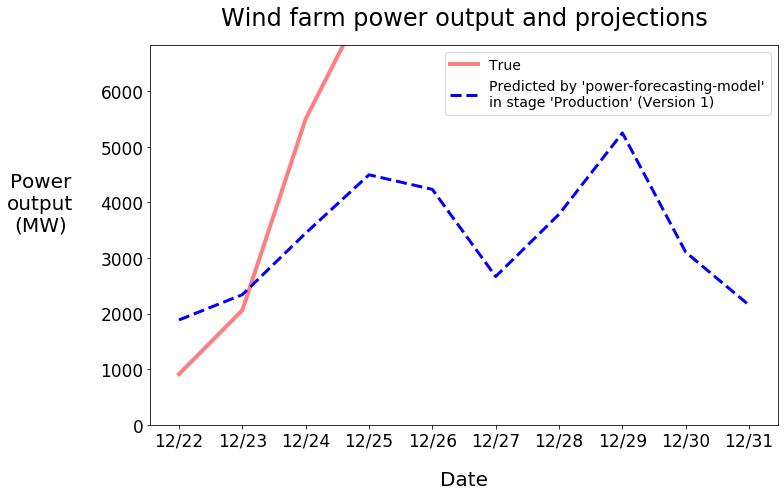

In [0]:
forecast_power(model_name, "Production")

# Create and deploy a new model version



## Create a new model version


In [0]:
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

with mlflow.start_run():
  n_estimators = 300
  mlflow.log_param("n_estimators", n_estimators)
  
  rand_forest = RandomForestRegressor(n_estimators=n_estimators)
  rand_forest.fit(X_train, y_train)

  val_x, val_y = get_validation_data()
  mse = mean_squared_error(rand_forest.predict(val_x), val_y)
  print("Validation MSE: %d" % mse)
  mlflow.log_metric("mse", mse)
  
  # Specify the `registered_model_name` parameter of the `mlflow.sklearn.log_model()`
  # function to register the model with the MLflow Model Registry. This automatically
  # creates a new model version
  mlflow.sklearn.log_model(
    sk_model=rand_forest,
    artifact_path="sklearn-model",
    registered_model_name=model_name,
  )

/databricks/spark/python/pyspark/sql/context.py:77: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 DeprecationWarning)
Validation MSE: 44960
Registered model 'power-forecasting-model' already exists. Creating a new version of this model...
2021/02/04 20:14:07 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: power-forecasting-model, version 2
Created version '2' of model 'power-forecasting-model'.

### Fetch the new model version ID using MLflow Model Registry Search



In [0]:
from mlflow.tracking.client import MlflowClient
client = MlflowClient()

model_version_infos = client.search_model_versions("name = '%s'" % model_name)
new_model_version = max([model_version_info.version for model_version_info in model_version_infos])

Wait for the new model version to become ready.

In [0]:
wait_until_ready(model_name, new_model_version)

Model status: READY

## Add a description to the new model version

In [0]:
client.update_model_version(
  name=model_name,
  version=new_model_version,
  description="This model version is a random forest containing 100 decision trees that was trained in scikit-learn."
)

Out[21]: <ModelVersion: creation_timestamp=1612469647314, current_stage='None', description=('This model version is a random forest containing 100 decision trees that was '
 'trained in scikit-learn.'), last_updated_timestamp=1612469656897, name='power-forecasting-model', run_id='d45b1ac942e34a0ca59d408309605840', run_link='', source='dbfs:/databricks/mlflow-tracking/2314812274044967/d45b1ac942e34a0ca59d408309605840/artifacts/sklearn-model', status='READY', status_message='', tags={}, user_id='1486628617178110', version='2'>

## Transition the new model version to Staging

Before deploying a model to a production application, it is often best practice to test it in a staging environment. The following cells transition the new model version to **Staging** and evaluate its performance.

In [0]:
client.transition_model_version_stage(
  name=model_name,
  version=new_model_version,
  stage="Staging",
)

Out[22]: <ModelVersion: creation_timestamp=1612469647314, current_stage='Staging', description=('This model version is a random forest containing 100 decision trees that was '
 'trained in scikit-learn.'), last_updated_timestamp=1612469656979, name='', run_id='d45b1ac942e34a0ca59d408309605840', run_link='', source='dbfs:/databricks/mlflow-tracking/2314812274044967/d45b1ac942e34a0ca59d408309605840/artifacts/sklearn-model', status='READY', status_message='', tags={}, user_id='1486628617178110', version='2'>

Evaluate the new model's forecasting performance in **Staging**

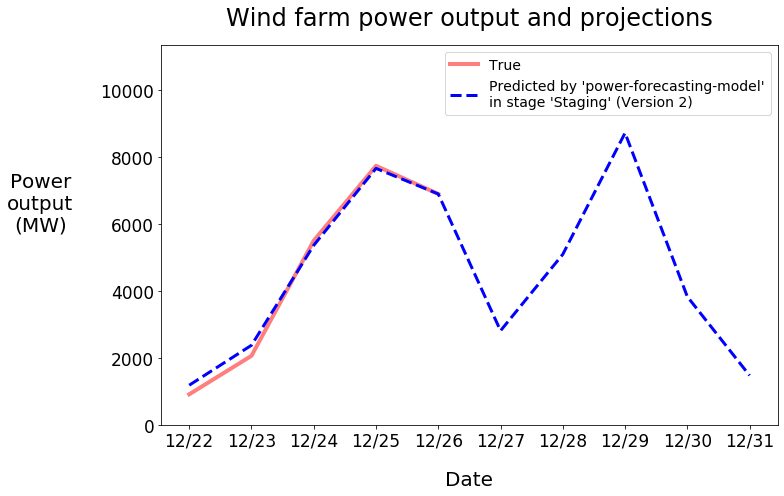

In [0]:
forecast_power(model_name, "Staging")

## Transition the new model version to **Production**




### Transition the new model version to Production using the API

In [0]:
client.transition_model_version_stage(
  name=model_name,
  version=new_model_version,
  stage="Production",
)

Out[24]: <ModelVersion: creation_timestamp=1612469647314, current_stage='Production', description=('This model version is a random forest containing 100 decision trees that was '
 'trained in scikit-learn.'), last_updated_timestamp=1612469659618, name='', run_id='d45b1ac942e34a0ca59d408309605840', run_link='', source='dbfs:/databricks/mlflow-tracking/2314812274044967/d45b1ac942e34a0ca59d408309605840/artifacts/sklearn-model', status='READY', status_message='', tags={}, user_id='1486628617178110', version='2'>

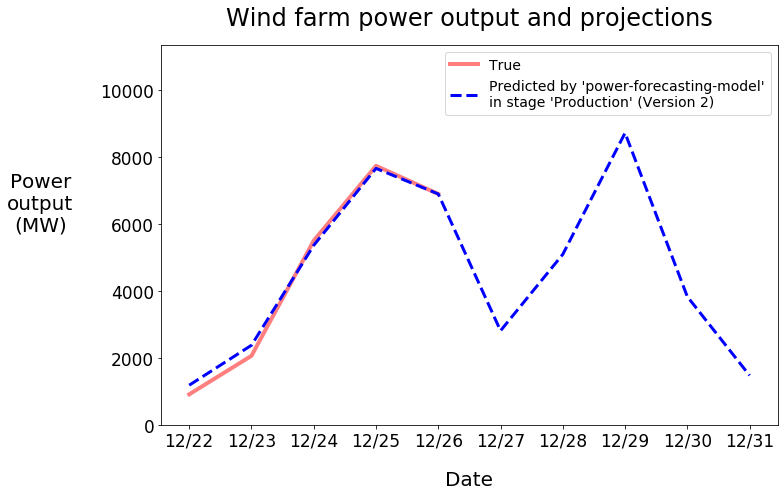

In [0]:
forecast_power(model_name, "Production")

# Archive and delete models



### Archive `Version 1` using the MLflow API



In [0]:
from mlflow.tracking.client import MlflowClient

client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=1,
  stage="Archived",
)

Out[26]: <ModelVersion: creation_timestamp=1612469631744, current_stage='Archived', description=('This model version was built using TensorFlow Keras. It is a feed-forward '
 'neural network with one hidden layer.'), last_updated_timestamp=1612469661931, name='', run_id='41c0dd1acaf74ad8b35b76169fdebe41', run_link='', source='dbfs:/databricks/mlflow-tracking/2314812274044967/41c0dd1acaf74ad8b35b76169fdebe41/artifacts/model', status='READY', status_message='', tags={}, user_id='1486628617178110', version='1'>

### Delete `Version 1` using the MLflow API

The following cell permanently deletes `Version 1` of the power forecasting model.

In [0]:
client.delete_model_version(
 name=model_name,
 version=1,
)

## Delete the power forecasting model

If you want to delete an entire registered model, including all of its model versions, you can use the `MlflowClient.delete_registered_model()` to do so. This action cannot be undone. You must first transition all model version stages to **None** or **Archived**.

**Warning: The following cell permanently deletes the power forecasting model, including all of its versions.**

In [0]:
client.transition_model_version_stage(
  name=model_name,
  version=2,
  stage="Archived"
)

client.delete_registered_model(name=model_name)